In [1]:
# Feature Selection & Importance Analysis
# Identify the most valuable features for modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

print("=" * 70)
print("FEATURE SELECTION & IMPORTANCE ANALYSIS")
print("=" * 70)

FEATURE SELECTION & IMPORTANCE ANALYSIS


In [2]:
# =============================================================================
# 1. LOAD ENGINEERED FEATURES
# =============================================================================

print("\n📂 LOADING ENGINEERED FEATURES...")
print("-" * 70)

# Load train set
train_path = Path('../data/processed/features_train.csv')
df_train = pd.read_csv(train_path)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

print(f"✓ Loaded training data: {len(df_train):,} records")
print(f"  Features: {len(df_train.columns)}")


📂 LOADING ENGINEERED FEATURES...
----------------------------------------------------------------------
✓ Loaded training data: 15,789 records
  Features: 271


In [3]:
# =============================================================================
# 2. PREPARE FEATURES AND TARGET
# =============================================================================

print("\n" + "=" * 70)
print("🎯 PREPARING FEATURES AND TARGET")
print("=" * 70)

# Define target
target = 'aqi'

# Features to exclude
exclude_features = [
    'timestamp', 'aqi', 'aqi_original', 'date',
    'city_name', 'country_code', 'source', 'location',
    'city', 'country', 'state', 'latitude', 'longitude',
    'aqi_category'  # Don't use category as feature (data leakage)
]

# Remove aqi_cat_ columns (one-hot encoded categories - data leakage)
aqi_cat_cols = [c for c in df_train.columns if c.startswith('aqi_cat_')]
exclude_features.extend(aqi_cat_cols)

# Select numeric features
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_features if c not in exclude_features]

print(f"Target variable: {target}")
print(f"Total features available: {len(feature_cols)}")

# Create feature matrix and target vector
# Use only complete cases
df_complete = df_train[feature_cols + [target]].dropna()

print(f"\nComplete cases: {len(df_complete):,} ({len(df_complete)/len(df_train)*100:.1f}%)")

if len(df_complete) < 100:
    print("⚠️  Warning: Very few complete cases!")
    print("   Consider imputing missing values or reducing features")

X = df_complete[feature_cols]
y = df_complete[target]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


🎯 PREPARING FEATURES AND TARGET
Target variable: aqi
Total features available: 253

Complete cases: 14,109 (89.4%)

Feature matrix shape: (14109, 253)
Target vector shape: (14109,)



🔗 CORRELATION ANALYSIS
Top 20 features by correlation with AQI:
----------------------------------------------------------------------
 1. aqi_rolling_3h_mean                                0.9525
 2. aqi_rolling_6h_mean                                0.9310
 3. aqi_rolling_3h_min                                 0.9284
 4. aqi_rolling_6h_min                                 0.9157
 5. aqi_rolling_12h_mean                               0.9080
 6. aqi_rolling_12h_min                                0.8973
 7. aqi_rolling_3h_max                                 0.8918
 8. aqi_rolling_24h_mean                               0.8854
 9. total_pm                                           0.8767
10. aqi_rolling_24h_min                                0.8706
11. pm25                                               0.8695
12. pm25_rolling_3h_max                                0.8693
13. pm25_rolling_3h_mean                               0.8682
14. pm10_rolling_3h_max                                0.8

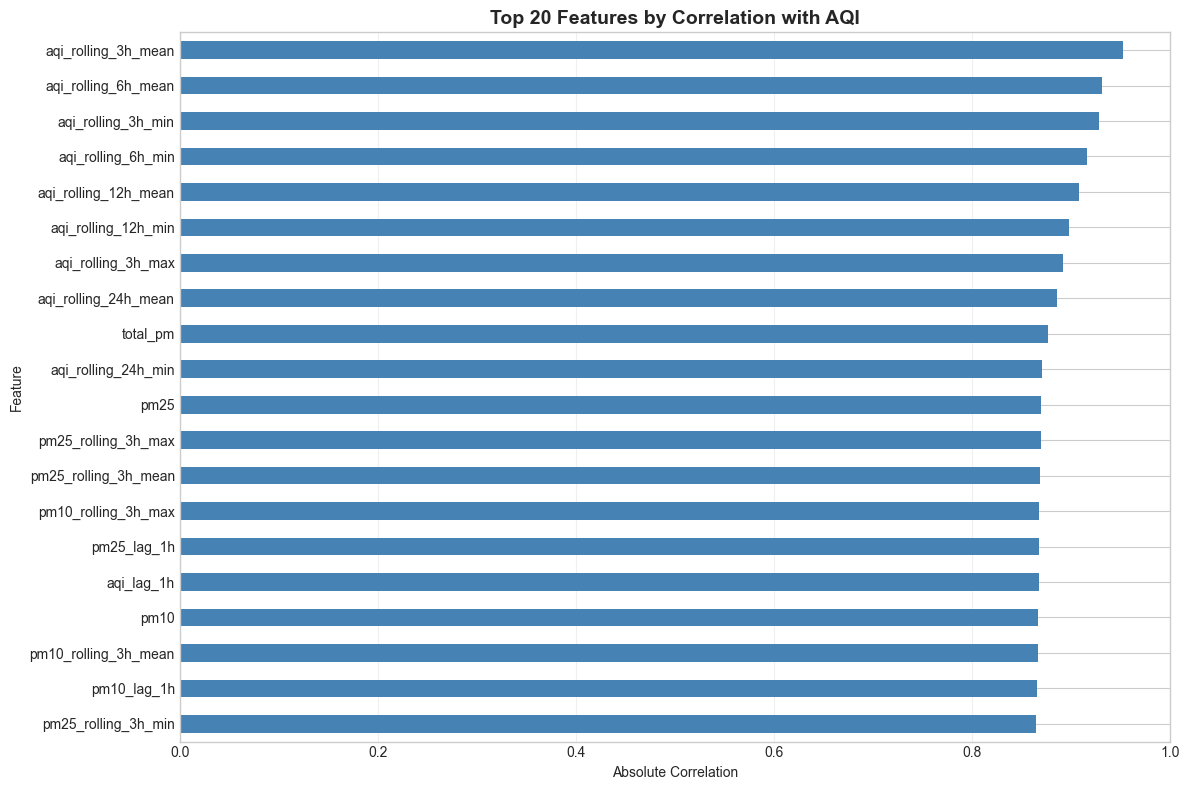

In [4]:
# =============================================================================
# 3. CORRELATION ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("🔗 CORRELATION ANALYSIS")
print("=" * 70)

# Calculate correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("Top 20 features by correlation with AQI:")
print("-" * 70)
for i, (feature, corr) in enumerate(correlations.head(20).items(), 1):
    print(f"{i:2d}. {feature:<50} {corr:.4f}")

# Visualize top correlations
fig, ax = plt.subplots(figsize=(12, 8))
correlations.head(20).sort_values().plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 Features by Correlation with AQI', fontweight='bold', fontsize=14)
ax.set_xlabel('Absolute Correlation')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


ℹ️ MUTUAL INFORMATION ANALYSIS
Calculating mutual information scores...

Top 20 features by Mutual Information:
----------------------------------------------------------------------
 1. pm25                                               4.8195
 2. aqi_rolling_3h_max                                 3.3706
 3. pm25_rolling_3h_max                                3.3518
 4. aqi_rolling_3h_min                                 3.1658
 5. pm25_rolling_3h_min                                3.1633
 6. aqi_rolling_3h_mean                                2.7999
 7. pm25_rolling_6h_max                                2.7949
 8. pm25_rolling_3h_mean                               2.7897
 9. aqi_rolling_6h_max                                 2.7803
10. pm25_lag_1h                                        2.7498
11. aqi_lag_1h                                         2.7158
12. pm25_rolling_6h_min                                2.5520
13. aqi_rolling_6h_min                                 2.5471
14. pm25_r

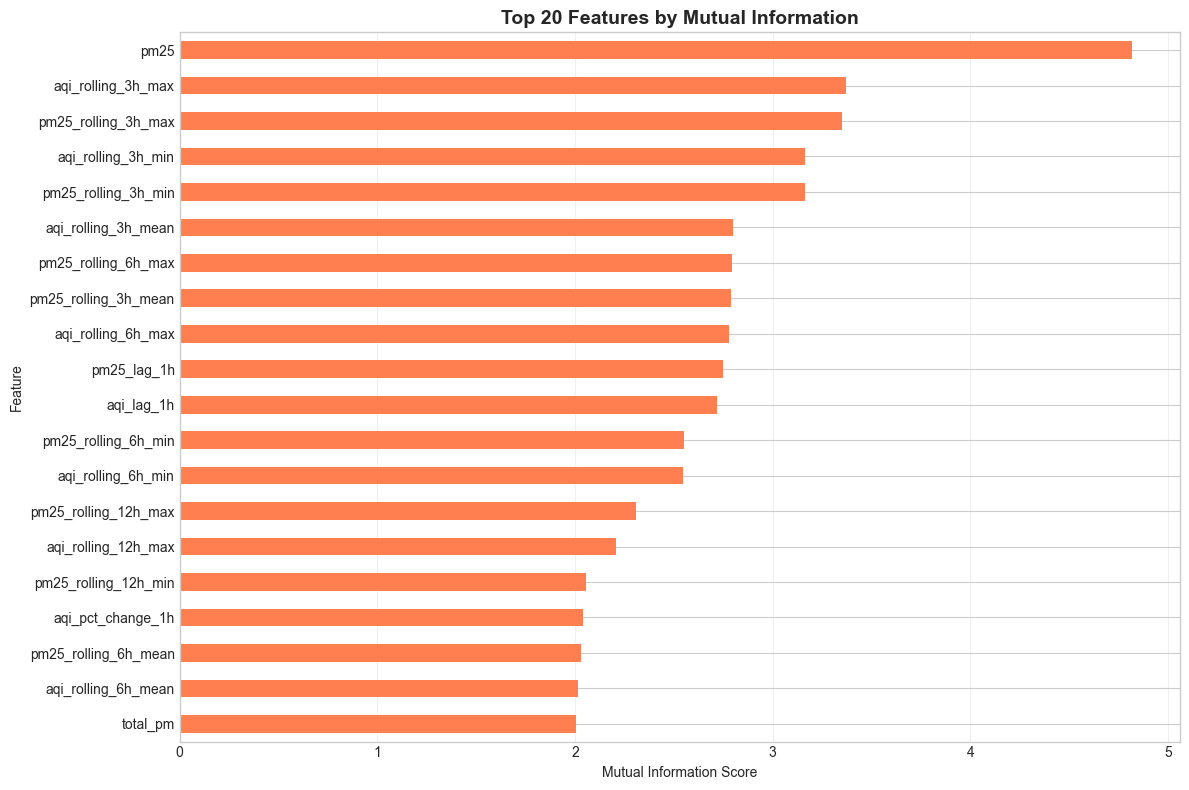

In [5]:
# =============================================================================
# 4. MUTUAL INFORMATION
# =============================================================================

print("\n" + "=" * 70)
print("ℹ️ MUTUAL INFORMATION ANALYSIS")
print("=" * 70)

print("Calculating mutual information scores...")

# Sample for speed if dataset is large
if len(X) > 10000:
    sample_indices = np.random.choice(len(X), 10000, replace=False)
    X_sample = X.iloc[sample_indices]
    y_sample = y.iloc[sample_indices]
else:
    X_sample = X
    y_sample = y

# Calculate MI scores
mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)
mi_scores = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

print("\nTop 20 features by Mutual Information:")
print("-" * 70)
for i, (feature, score) in enumerate(mi_scores.head(20).items(), 1):
    print(f"{i:2d}. {feature:<50} {score:.4f}")

# Visualize MI scores
fig, ax = plt.subplots(figsize=(12, 8))
mi_scores.head(20).sort_values().plot(kind='barh', ax=ax, color='coral')
ax.set_title('Top 20 Features by Mutual Information', fontweight='bold', fontsize=14)
ax.set_xlabel('Mutual Information Score')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


🌲 RANDOM FOREST FEATURE IMPORTANCE
Training Random Forest model...
✓ Model trained on 14,109 samples
  R² score: 0.9997

Top 20 features by Random Forest importance:
----------------------------------------------------------------------
 1. aqi_rolling_3h_mean                                0.6887
 2. pm25                                               0.2170
 3. aqi_change_24h                                     0.0619
 4. aqi_change_6h                                      0.0200
 5. aqi_change_12h                                     0.0055
 6. pm25_rolling_3h_min                                0.0007
 7. aqi_rolling_3h_min                                 0.0005
 8. total_pm                                           0.0004
 9. aqi_rolling_3h_max                                 0.0003
10. pm10_rolling_12h_max                               0.0003
11. pm25_rolling_72h_std                               0.0003
12. pm10_lag_1h                                        0.0002
13. pm25_rolling_2

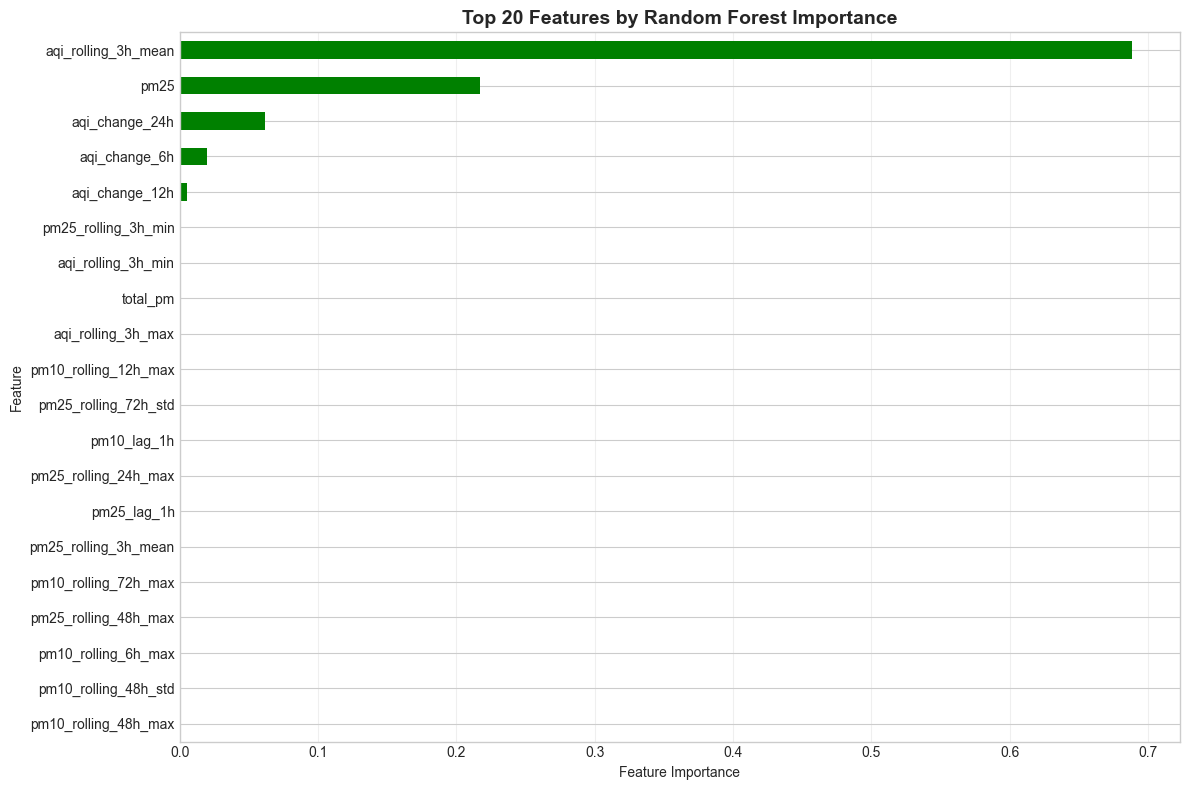

In [7]:
# =============================================================================
# 5. RANDOM FOREST FEATURE IMPORTANCE
# =============================================================================

print("\n" + "=" * 70)
print("🌲 RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 70)

print("Training Random Forest model...")

# Sample for speed
if len(X) > 15000:
    sample_indices = np.random.choice(len(X), 15000, replace=False)
    X_rf = X.iloc[sample_indices]
    y_rf = y.iloc[sample_indices]
else:
    X_rf = X
    y_rf = y

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_rf, y_rf)

print(f"✓ Model trained on {len(X_rf):,} samples")
print(f"  R² score: {rf.score(X_rf, y_rf):.4f}")

# Get feature importance
rf_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("\nTop 20 features by Random Forest importance:")
print("-" * 70)
for i, (feature, importance) in enumerate(rf_importance.head(20).items(), 1):
    print(f"{i:2d}. {feature:<50} {importance:.4f}")

# Visualize RF importance
fig, ax = plt.subplots(figsize=(12, 8))
rf_importance.head(20).sort_values().plot(kind='barh', ax=ax, color='green')
ax.set_title('Top 20 Features by Random Forest Importance', fontweight='bold', fontsize=14)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


📈 GRADIENT BOOSTING FEATURE IMPORTANCE
Training Gradient Boosting model...
✓ Model trained on 14,109 samples
  R² score: 1.0000

Top 20 features by Gradient Boosting importance:
----------------------------------------------------------------------
 1. aqi_rolling_3h_mean                                0.6879
 2. pm25                                               0.2191
 3. aqi_change_24h                                     0.0883
 4. pm25_rolling_72h_max                               0.0010
 5. aqi_lag_1h                                         0.0006
 6. pm25_lag_168h                                      0.0006
 7. pm25_rolling_3h_min                                0.0003
 8. pm10                                               0.0003
 9. total_pm                                           0.0002
10. pm10_lag_6h                                        0.0002
11. aqi_rolling_6h_min                                 0.0002
12. aqi_rolling_12h_max                                0.0002
13. pm

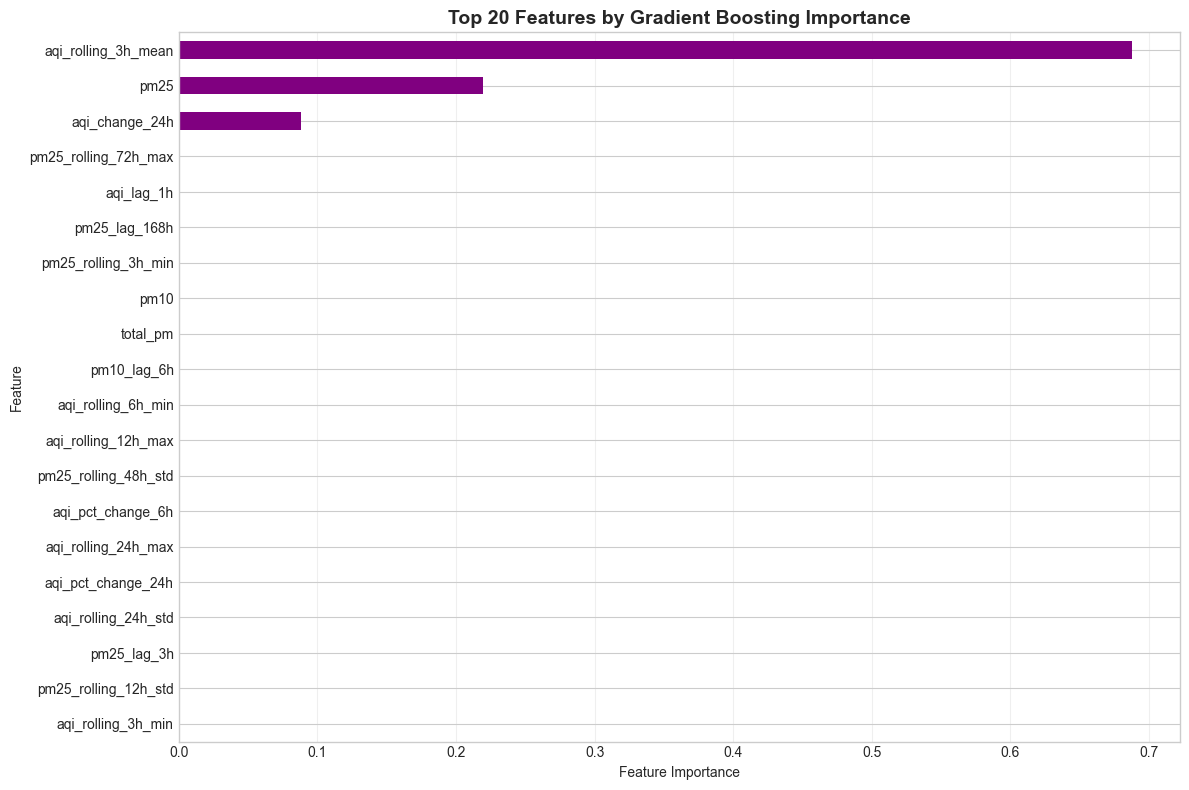

In [8]:
# =============================================================================
# 6. GRADIENT BOOSTING FEATURE IMPORTANCE
# =============================================================================

print("\n" + "=" * 70)
print("📈 GRADIENT BOOSTING FEATURE IMPORTANCE")
print("=" * 70)

print("Training Gradient Boosting model...")

# Train Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

gb.fit(X_rf, y_rf)

print(f"✓ Model trained on {len(X_rf):,} samples")
print(f"  R² score: {gb.score(X_rf, y_rf):.4f}")

# Get feature importance
gb_importance = pd.Series(gb.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("\nTop 20 features by Gradient Boosting importance:")
print("-" * 70)
for i, (feature, importance) in enumerate(gb_importance.head(20).items(), 1):
    print(f"{i:2d}. {feature:<50} {importance:.4f}")

# Visualize GB importance
fig, ax = plt.subplots(figsize=(12, 8))
gb_importance.head(20).sort_values().plot(kind='barh', ax=ax, color='purple')
ax.set_title('Top 20 Features by Gradient Boosting Importance', fontweight='bold', fontsize=14)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



📊 COMBINED FEATURE IMPORTANCE ANALYSIS
Top 30 features by combined importance:
----------------------------------------------------------------------
                      Correlation  Mutual_Info  Random_Forest  Gradient_Boost  \
aqi_rolling_3h_mean        1.0000       0.5810         1.0000          1.0000   
pm25                       0.9129       1.0000         0.3150          0.3185   
aqi_rolling_3h_max         0.9363       0.6994         0.0004          0.0000   
aqi_rolling_3h_min         0.9747       0.6569         0.0007          0.0001   
pm25_rolling_3h_max        0.9126       0.6955         0.0000          0.0000   
pm25_rolling_3h_min        0.9074       0.6564         0.0010          0.0005   
pm25_rolling_3h_mean       0.9115       0.5788         0.0003          0.0001   
aqi_rolling_6h_min         0.9614       0.5285         0.0000          0.0003   
pm25_rolling_6h_max        0.9061       0.5799         0.0001          0.0000   
pm25_lag_1h                0.9105      

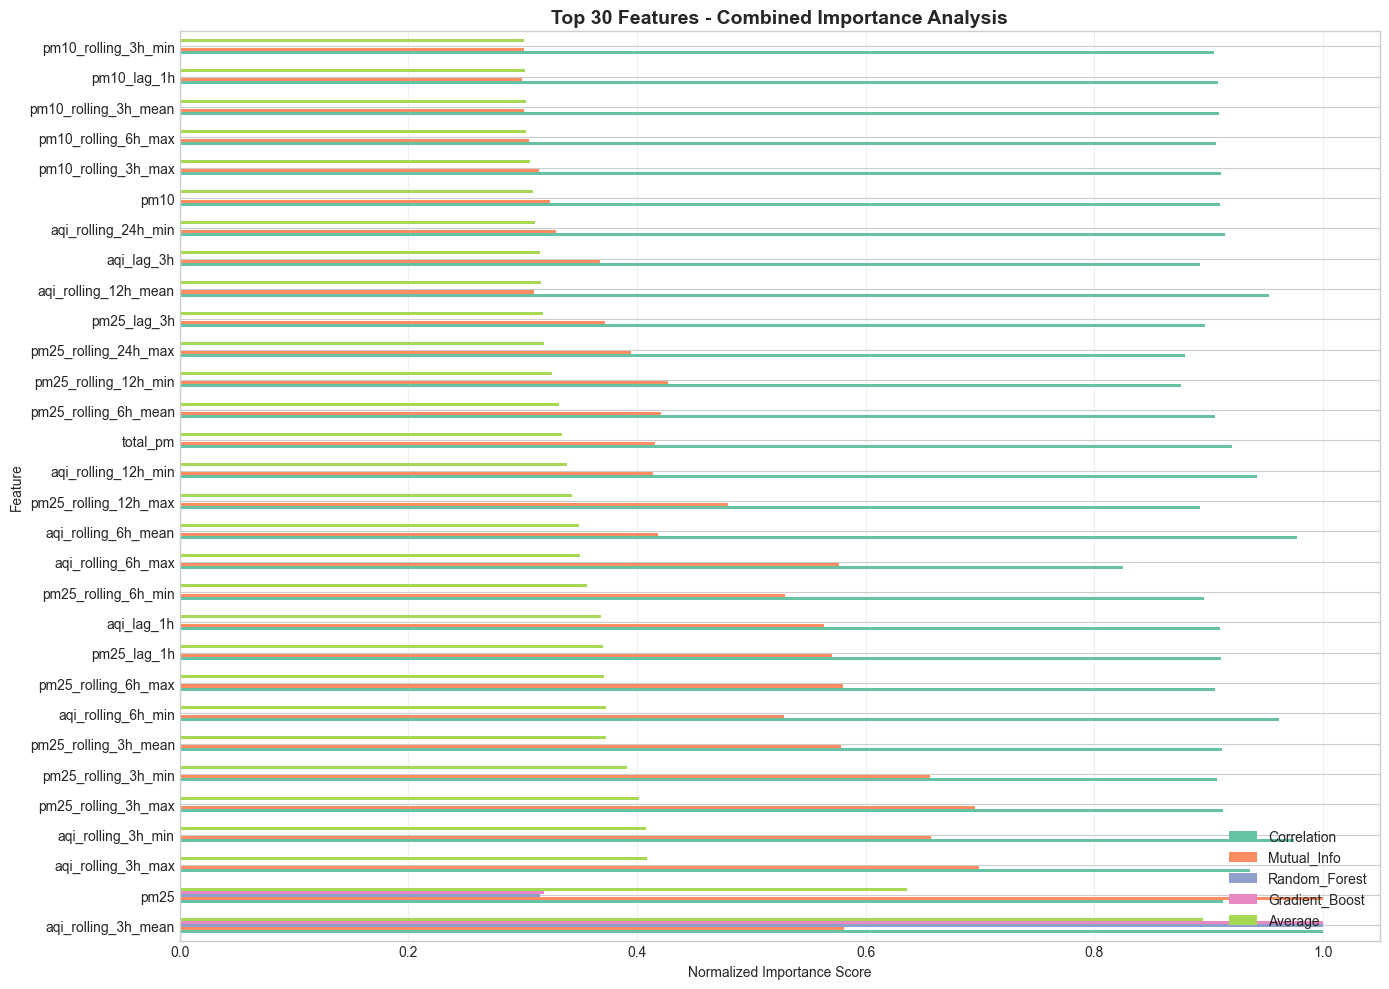

In [9]:
# =============================================================================
# 7. FEATURE IMPORTANCE COMPARISON
# =============================================================================

print("\n" + "=" * 70)
print("📊 COMBINED FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Normalize all importance scores to 0-1
corr_norm = (correlations - correlations.min()) / (correlations.max() - correlations.min())
mi_norm = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min())
rf_norm = (rf_importance - rf_importance.min()) / (rf_importance.max() - rf_importance.min())
gb_norm = (gb_importance - gb_importance.min()) / (gb_importance.max() - gb_importance.min())

# Combine scores (equal weight)
combined_importance = pd.DataFrame({
    'Correlation': corr_norm,
    'Mutual_Info': mi_norm,
    'Random_Forest': rf_norm,
    'Gradient_Boost': gb_norm
})

combined_importance['Average'] = combined_importance.mean(axis=1)
combined_importance = combined_importance.sort_values('Average', ascending=False)

print("Top 30 features by combined importance:")
print("-" * 70)
print(combined_importance.head(30).round(4))

# Visualize combined importance
fig, ax = plt.subplots(figsize=(14, 10))
combined_importance.head(30).plot(kind='barh', ax=ax, stacked=False)
ax.set_title('Top 30 Features - Combined Importance Analysis', fontweight='bold', fontsize=14)
ax.set_xlabel('Normalized Importance Score')
ax.set_ylabel('Feature')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [10]:
# =============================================================================
# 8. FEATURE SELECTION RECOMMENDATIONS
# =============================================================================

print("\n" + "=" * 70)
print("🎯 FEATURE SELECTION RECOMMENDATIONS")
print("=" * 70)

# Select features based on combined importance
importance_threshold = 0.3  # Features with avg importance > 0.3

selected_features = combined_importance[combined_importance['Average'] > importance_threshold].index.tolist()

print(f"Recommendation: Select top features with avg importance > {importance_threshold}")
print(f"\nSelected features: {len(selected_features)}")
print("-" * 70)

# Group features by type
feature_groups = {
    'Lag Features': [f for f in selected_features if 'lag' in f],
    'Rolling Stats': [f for f in selected_features if 'rolling' in f],
    'Rate of Change': [f for f in selected_features if 'change' in f],
    'Weather': [f for f in selected_features if any(w in f for w in ['temp', 'humid', 'pressure', 'wind'])],
    'Pollutants': [f for f in selected_features if any(p in f for p in ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co'])],
    'Temporal': [f for f in selected_features if any(t in f for t in ['hour', 'dow', 'month', 'weekend', 'rush'])],
    'Geographic': [f for f in selected_features if 'city' in f or 'country' in f],
    'Other': []
}

# Categorize remaining
for feature in selected_features:
    categorized = False
    for group_name, group_features in feature_groups.items():
        if feature in group_features:
            categorized = True
            break
    if not categorized and group_name != 'Other':
        feature_groups['Other'].append(feature)

print("\nSelected features by category:")
for group_name, group_features in feature_groups.items():
    if group_features:
        print(f"\n{group_name} ({len(group_features)}):")
        for f in group_features[:10]:  # Show first 10
            print(f"  - {f}")
        if len(group_features) > 10:
            print(f"  ... and {len(group_features) - 10} more")


🎯 FEATURE SELECTION RECOMMENDATIONS
Recommendation: Select top features with avg importance > 0.3

Selected features: 33
----------------------------------------------------------------------

Selected features by category:

Lag Features (5):
  - pm25_lag_1h
  - aqi_lag_1h
  - pm25_lag_3h
  - aqi_lag_3h
  - pm10_lag_1h

Rolling Stats (25):
  - aqi_rolling_3h_mean
  - aqi_rolling_3h_max
  - aqi_rolling_3h_min
  - pm25_rolling_3h_max
  - pm25_rolling_3h_min
  - pm25_rolling_3h_mean
  - aqi_rolling_6h_min
  - pm25_rolling_6h_max
  - pm25_rolling_6h_min
  - aqi_rolling_6h_max
  ... and 15 more

Pollutants (21):
  - pm25
  - pm25_rolling_3h_max
  - pm25_rolling_3h_min
  - pm25_rolling_3h_mean
  - pm25_rolling_6h_max
  - pm25_lag_1h
  - pm25_rolling_6h_min
  - pm25_rolling_12h_max
  - pm25_rolling_6h_mean
  - pm25_rolling_12h_min
  ... and 11 more



🔍 MULTICOLLINEARITY ANALYSIS
Found 377 highly correlated feature pairs (>0.9):
----------------------------------------------------------------------
  aqi_rolling_3h_mean                      <-> pm25                                     0.908
  aqi_rolling_3h_mean                      <-> aqi_rolling_3h_max                       0.937
  aqi_rolling_3h_mean                      <-> aqi_rolling_3h_min                       0.973
  aqi_rolling_3h_mean                      <-> pm25_rolling_3h_max                      0.913
  aqi_rolling_3h_mean                      <-> pm25_rolling_3h_min                      0.906
  aqi_rolling_3h_mean                      <-> pm25_rolling_3h_mean                     0.911
  aqi_rolling_3h_mean                      <-> aqi_rolling_6h_min                       0.962
  aqi_rolling_3h_mean                      <-> pm25_rolling_6h_max                      0.910
  aqi_rolling_3h_mean                      <-> pm25_lag_1h                              0.910
  a

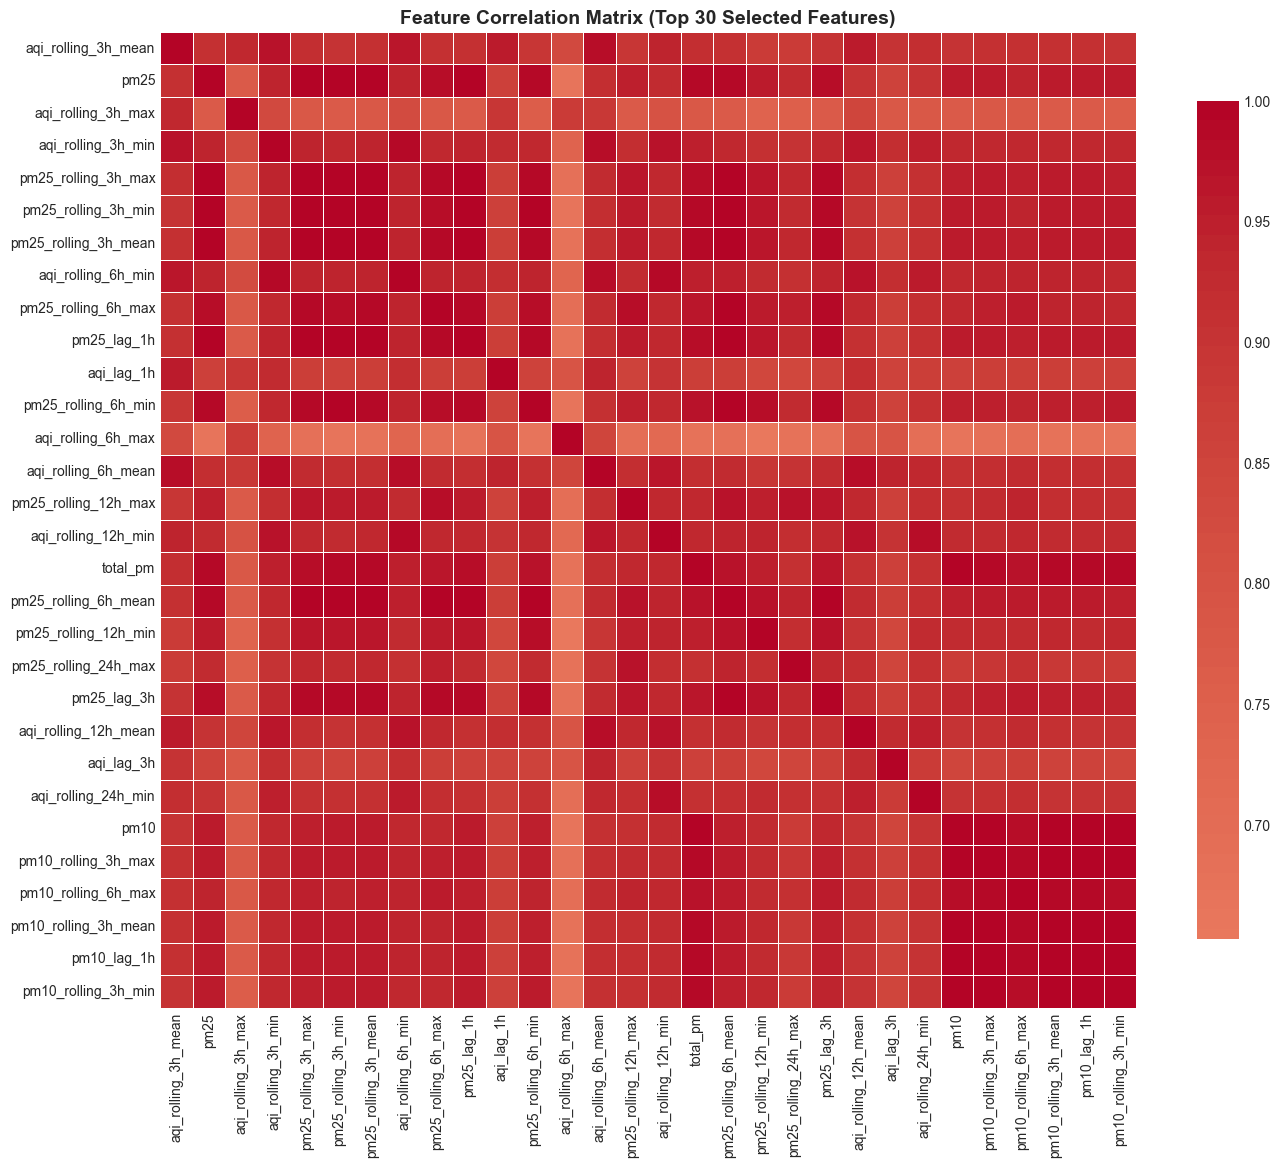

In [11]:
# =============================================================================
# 9. MULTICOLLINEARITY CHECK
# =============================================================================

print("\n" + "=" * 70)
print("🔍 MULTICOLLINEARITY ANALYSIS")
print("=" * 70)

# Check correlation among selected features
X_selected = X[selected_features]

# Calculate correlation matrix
corr_matrix = X_selected.corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.9):")
    print("-" * 70)
    for feat1, feat2, corr in high_corr_pairs[:20]:  # Show first 20
        print(f"  {feat1:<40} <-> {feat2:<40} {corr:.3f}")
    
    if len(high_corr_pairs) > 20:
        print(f"  ... and {len(high_corr_pairs) - 20} more pairs")
    
    print("\n⚠️  Recommendation: Consider removing one feature from each highly correlated pair")
else:
    print("✓ No highly correlated feature pairs found")

# Visualize correlation matrix (sample of features)
if len(selected_features) <= 30:
    features_to_plot = selected_features
else:
    features_to_plot = selected_features[:30]

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(X[features_to_plot].corr(), 
            annot=False, 
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Feature Correlation Matrix (Top 30 Selected Features)', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()



📐 PRINCIPAL COMPONENT ANALYSIS
Total features: 33
Components for 95% variance: 3
Components for 99% variance: 8


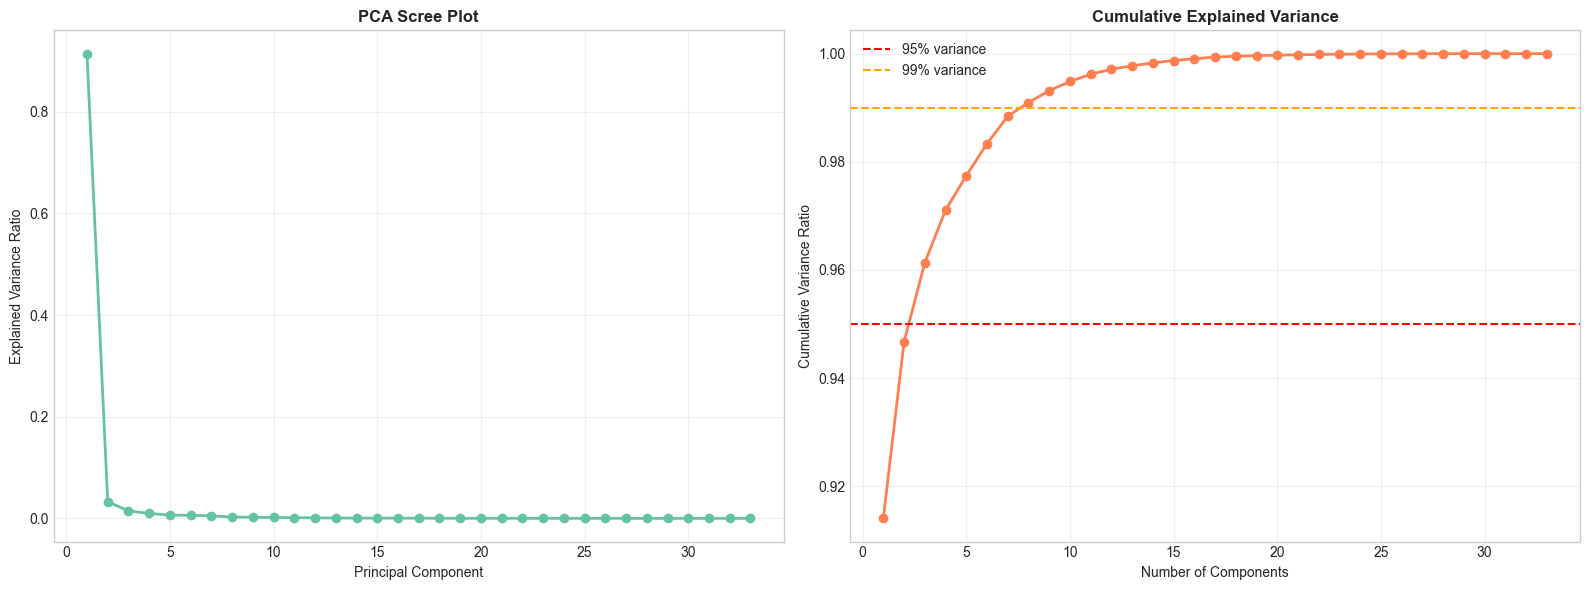


💡 PCA Insight: Can reduce from 33 to 3 features
   while retaining 95% of information


In [12]:
# =============================================================================
# 10. PCA ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("📐 PRINCIPAL COMPONENT ANALYSIS")
print("=" * 70)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Total features: {len(selected_features)}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {np.argmax(cumulative_variance >= 0.99) + 1}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, 
            marker='o', linewidth=2)
axes[0].set_title('PCA Scree Plot', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1),
            cumulative_variance, 
            marker='o', linewidth=2, color='coral')
axes[1].axhline(0.95, color='red', linestyle='--', label='95% variance')
axes[1].axhline(0.99, color='orange', linestyle='--', label='99% variance')
axes[1].set_title('Cumulative Explained Variance', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 PCA Insight: Can reduce from {len(selected_features)} to {n_components_95} features")
print(f"   while retaining 95% of information")


In [13]:
# =============================================================================
# 11. FINAL FEATURE RECOMMENDATIONS
# =============================================================================

print("\n" + "=" * 70)
print("✅ FINAL FEATURE SELECTION RECOMMENDATIONS")
print("=" * 70)

# Create three feature sets
feature_sets = {}

# 1. Top 20 features (minimal set)
feature_sets['minimal'] = combined_importance.head(20).index.tolist()

# 2. Top 50 features (balanced set)
feature_sets['balanced'] = combined_importance.head(50).index.tolist()

# 3. Selected features (comprehensive set)
feature_sets['comprehensive'] = selected_features

print("Three recommended feature sets:\n")

for set_name, features in feature_sets.items():
    print(f"{set_name.upper()} SET ({len(features)} features):")
    print(f"  Use case: ", end="")
    
    if set_name == 'minimal':
        print("Fast prototyping, simple models")
    elif set_name == 'balanced':
        print("Good balance of performance and speed")
    else:
        print("Maximum accuracy, complex models")
    
    print(f"  Features: {features[:5]}...")
    print()



✅ FINAL FEATURE SELECTION RECOMMENDATIONS
Three recommended feature sets:

MINIMAL SET (20 features):
  Use case: Fast prototyping, simple models
  Features: ['aqi_rolling_3h_mean', 'pm25', 'aqi_rolling_3h_max', 'aqi_rolling_3h_min', 'pm25_rolling_3h_max']...

BALANCED SET (50 features):
  Use case: Good balance of performance and speed
  Features: ['aqi_rolling_3h_mean', 'pm25', 'aqi_rolling_3h_max', 'aqi_rolling_3h_min', 'pm25_rolling_3h_max']...

COMPREHENSIVE SET (33 features):
  Use case: Maximum accuracy, complex models
  Features: ['aqi_rolling_3h_mean', 'pm25', 'aqi_rolling_3h_max', 'aqi_rolling_3h_min', 'pm25_rolling_3h_max']...



In [14]:
# =============================================================================
# 12. SAVE FEATURE SELECTION RESULTS
# =============================================================================

print("\n" + "=" * 70)
print("💾 SAVING FEATURE SELECTION RESULTS")
print("=" * 70)

output_dir = Path('../data/processed')

# Save combined importance scores
importance_path = output_dir / 'feature_importance_scores.csv'
combined_importance.to_csv(importance_path)
print(f"✓ Saved: {importance_path}")

# Save feature sets
import json

feature_sets_path = output_dir / 'feature_sets.json'
with open(feature_sets_path, 'w') as f:
    json.dump(feature_sets, f, indent=2)
print(f"✓ Saved: {feature_sets_path}")

# Save recommendation summary
recommendations = {
    'total_features_engineered': len(feature_cols),
    'features_analyzed': len(X.columns),
    'features_recommended': {
        'minimal': len(feature_sets['minimal']),
        'balanced': len(feature_sets['balanced']),
        'comprehensive': len(feature_sets['comprehensive'])
    },
    'pca_recommendation': {
        'original_features': len(selected_features),
        'components_for_95pct': int(n_components_95)
    },
    'high_correlation_pairs': len(high_corr_pairs)
}

summary_path = output_dir / 'feature_selection_summary.json'
with open(summary_path, 'w') as f:
    json.dump(recommendations, f, indent=2)
print(f"✓ Saved: {summary_path}")

print("\n" + "=" * 70)
print("✅ FEATURE SELECTION COMPLETE!")
print("=" * 70)

print("\n📊 Summary:")
print(f"  Features engineered: {len(feature_cols)}")
print(f"  Features selected (comprehensive): {len(selected_features)}")
print(f"  Reduction: {(1 - len(selected_features)/len(feature_cols))*100:.1f}%")

print("\n🎯 Recommended Feature Sets:")
for set_name, features in feature_sets.items():
    print(f"  {set_name.capitalize():.<20} {len(features)} features")

print("\n📈 Next Steps:")
print("1. Use 'balanced' set (50 features) for initial modeling")
print("2. Try 'comprehensive' set if computational resources allow")
print("3. Consider PCA for dimensionality reduction")
print("4. Proceed to Phase 5: Model Training")


💾 SAVING FEATURE SELECTION RESULTS
✓ Saved: ..\data\processed\feature_importance_scores.csv
✓ Saved: ..\data\processed\feature_sets.json
✓ Saved: ..\data\processed\feature_selection_summary.json

✅ FEATURE SELECTION COMPLETE!

📊 Summary:
  Features engineered: 253
  Features selected (comprehensive): 33
  Reduction: 87.0%

🎯 Recommended Feature Sets:
  Minimal............. 20 features
  Balanced............ 50 features
  Comprehensive....... 33 features

📈 Next Steps:
1. Use 'balanced' set (50 features) for initial modeling
2. Try 'comprehensive' set if computational resources allow
3. Consider PCA for dimensionality reduction
4. Proceed to Phase 5: Model Training
